### Todo

Add PCA and AutoEncoder funtionality.

How do we deal with outliers

Derived statistics: Sloope, Average, Max/Min

Discuss HVLT correlation/should we use them with andrijana



#### This cell is for defining various OPTIONS used for this notebook (working directory, how many rows and columns pandas displays for a dataframe, etc). 

#### Preferably this cell is also where we do important imports (for example pandas and numpy)

In [35]:
import os 
#Input the directory where your joined_data.csv is located 
#os.chdir('C:/Users/Trond/Documents/Master 2020/Processed data')
os.chdir('C:/Users/Briggstone/Documents/Master 2020/Processed data')
# os.chdir('C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data')

#Where you want the csv file of the merged data to be placed
output_filepath = 'C:/Users/Briggstone/Documents/Master 2020/Processed data'
#output_filepath = 'C:/Users/Trond/Documents/Master 2020/Processed data'
#output_filepath = 'C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data'

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split

# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)


# Joined imputed data to import, 0 = MODE/MEAN IMPUTATION, 1 = SIMILARITY MEASURE
MV_FLAG = 0

#The portion of data in the test set
TEST_PORTION = 0.2

#### In this cell we import our joined imputed data based on MV_FLAG

In [36]:
if MV_FLAG == 0:
    data = pd.read_csv('joined_data_mm.csv') # missing values filled with mean/median
else: 
    data = pd.read_csv('joined_data_heom.csv') # missing values filled based on HEOM measure



#### In this cell we define the functions we need to calculate derived values from various variables

In [37]:
#Functions for calculating derived values for various data tables


def hvlttot (df):
    
    component_vars = ["HVLTRT1", "HVLTRT2", "HVLTRT3", "HVLTREC", "HVLTFPRL", "HVLTFPUN"]
    
    #Immediate/Total recall
    df["HVLT_TOTAL"] = df.loc[:,["HVLTRT1", "HVLTRT2", "HVLTRT3"]].sum(axis = 1)
    
    #Discrimination Recognition
    df["HVLT_DISCRIM"] = df.HVLTREC - (df.HVLTFPRL + df.HVLTFPUN)
    
    #Retention
    df["HVLT_RETENTION"] = df.HVLTRDLY / df.loc[:,["HVLTRT2", "HVLTRT3"]].max(axis = 1)
    
    df.drop(component_vars,inplace = True, axis = 1)
    
    
def mcatot (df):
    ''' Montreal cognitive test
    sum variables and 1 point to score if education years <= 12 and score < 30
    '''
    
    component_vars = ["MCAALTTM", "MCACUBE", "MCACLCKC", "MCACLCKN", "MCACLCKH", "MCALION", "MCARHINO", "MCACAMEL", \
    "MCAFDS", "MCABDS", "MCAVIGIL", "MCASER7", "MCASNTNC", "MCAVF", "MCAABSTR", "MCAREC1", "MCAREC2", "MCAREC3", "MCAREC4", \
    "MCAREC5", "MCADATE", "MCAMONTH", "MCAYR", "MCADAY", "MCAPLACE", "MCACITY"]
    
    df['MCATOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)
    
    df['MCATOT'] = df.apply(lambda row_wise: row_wise["MCATOT"] + 1 if row_wise["EDUCYRS"] <= 12 and row_wise["MCATOT"] < 30 else row_wise["MCATOT"] , axis=1)   
    

def vlttot (df):
    ''' Semantic Fluency
    VLTANIM, VLTVEG,VLTFRUIT need to be summed in order to obtain a final score'''
    
    component_vars = ["VLTANIM", "VLTVEG", "VLTFRUIT"]
    
    df['VLTTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

    
def remqtot (df):
    '''REM sleep behavior disorder (RBD)'''
    
    component_vars = ["STROKE","HETRA", "PARKISM", "RLS", "NARCLPSY", "DEPRS", "EPILEPSY", "BRNINFM", "CNSOTH"]
        
    score = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    
    # 1 point if any of these component variables had a 1, else 0
    score = pd.Series(np.where(score >= 1, 1, 0))
    
    df.drop(component_vars, inplace = True, axis = 1)

    component_vars = ["DRMVIVID", "DRMAGRAC", "DRMNOCTB", "SLPLMBMV", "SLPINJUR", \
                      "DRMVERBL", "DRMFIGHT", "DRMUMV", "DRMOBJFL", "MVAWAKEN", "DRMREMEM", "SLPDSTRB"]
    
    score += df.loc[:, component_vars].sum(axis = 1, skipna = False)

    df['REMTOT'] = score
    df.drop(component_vars, inplace = True, axis = 1)

    
def gdsstot (df):
    '''Geriatric Depression Scale'''
    
    component_vars = ["GDSSATIS", "GDSDROPD", \
    "GDSEMPTY", "GDSBORED", "GDSGSPIR", "GDSAFRAD", "GDSHAPPY", "GDSHLPLS", "GDSHOME", "GDSMEMRY", "GDSALIVE", "GDSWRTLS", "GDSENRGY", \
    "GDSHOPLS", "GDSBETER"]
    
    df['GDSSTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

    
def sidttot (df):
    '''Olfactory impairment: University of Pennsylvania Smell ID Test'''
    component_vars = ["UPSITBK1", "UPSITBK2", "UPSITBK3", "UPSITBK4"]
    
    df['SIDTTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

    
def epsstot (df):
    '''Epworth Sleepiness Scale'''
    
    component_vars = ["ESS1", "ESS2", \
    "ESS3", "ESS4", "ESS5", "ESS6", "ESS7", "ESS8"]
    
    df['EPSSTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

    
def scoptot(df):
    '''Scales for Outcomes in Parkinson’s Disease–Autonomic'''

    component_vars = ["SCAU1", "SCAU2", \
    "SCAU3", "SCAU4", "SCAU5", "SCAU6", "SCAU7", "SCAU8", "SCAU9", "SCAU10", "SCAU11", "SCAU12", "SCAU13", \
    "SCAU14", "SCAU15", "SCAU16", "SCAU17", "SCAU18", "SCAU19", "SCAU20", "SCAU21", "SCAU22", "SCAU23", "SCAU24", "SCAU25"]
    
    df['SCOPTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)
    

def msu3tot(df):
    '''Movement Disorders Society–Unified Parkinson Disease Rating Scale'''
    
    component_vars = ['NP3BRADY', 'NP3FACXP', 'NP3FRZGT', \
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML', 'NP3KTRMR', 'NP3LGAGL', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR', \
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'PN3RIGRL', 'NP3RIGN', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU', \
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR', 'NP3LGAGR', 'NP3RIGLU']
       
    df['MSU3TOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    #df.drop(component_vars, inplace = True, axis = 1) #cannot drop, variables needed in tremor and pigd

    
def tremor(df):
    '''Tremor score'''
    
    component_vars = ["NP2TRMR", "NP3PTRMR", "NP3PTRML", "NP3KTRMR", "NP3KTRML", "NP3RTARU", "NP3RTALU", "NP3RTARL", "NP3RTALL", \
    "NP3RTALJ", "NP3RTCON"]
    
    df['TREMOR'] = df.loc[:, component_vars].mean(axis = 1, skipna = False)
    #df.drop(component_vars, inplace = True, axis = 1) #cannot drop, variables needed in tremor and pigd
    
    
def pigd(df):
    '''PIGD score'''
    
    component_vars = ["NP2WALK", "NP2FREZ", "NP3GAIT", "NP3FRZGT", "NP3PSTBL"]
    df['PIGD'] = df.loc[:, component_vars].mean(axis = 1, skipna = False)
    
    component_vars = ['NP3BRADY', 'NP3FACXP', 'NP3FRZGT', \
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML', 'NP3KTRMR', 'NP3LGAGL', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR', \
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'PN3RIGRL', 'NP3RIGN', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU', \
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR', "NP2TRMR", "NP2WALK", "NP2FREZ", 'NP3LGAGR', 'NP3RIGLU']
    #cannot drop before we discuss missing values
    df.drop(component_vars, inplace = True, axis = 1) #drop everything from msu3tot, tremor and pig
    

def td_pigd_ratio(df):
    '''Tremor/PIGD ratio'''
    
    component_vars = ['TREMOR', 'PIGD']
    df['TD_PIGD_RATIO'] = df.apply(lambda x: ratio(x['TREMOR'], x['PIGD']), axis=1)
    df.drop(component_vars, inplace = True, axis = 1)

    
def ratio(x, y):
    ''' Calculate TD/PGID ratio'''
    
    if y == 0:
        if x == 0:
            ratio = 0 #indeterminate
        else: 
            ratio =1 #TD
    elif x/y >= 1.15:
        ratio = 1 #TD
    elif x/y <= 0.9:
        ratio = 2 #PIGD
    else:
        ratio = 0 #indeterminate 
    return ratio

#### In this cell we define functions for encoding and dichotomizing variables

In [38]:
#Functions for encoding and dichotomizing variables

def famhist(df):
    '''Family history of Parkinson's Disease'''
    
    component_vars = ["BIOMOMPD", "BIODADPD", "FULSIBPD", "HAFSIBPD", "MAGPARPD", "PAGPARPD", "MATAUPD", "PATAUPD", "KIDSPD"]
        
    score = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    
    # if score >= 1 then 1, else 0
    # if score = NaN, then 0
    score = pd.Series(np.where(score >= 1, 1, 0))
    
    df.drop(component_vars, inplace = True, axis = 1)
    df['FAMHIST'] = score
    
    
def sleepy(df):
    '''Dichotomize EPSSTOT, Epworth Sleepiness Scale'''
    
    # if score < 10 subjects will be classified as 0 (not sleepy)
    # if score >= 10 subject will be classified as 1 (sleepy).
    df['SLEEPY'] = df['EPSSTOT'].apply(lambda x: np.where(x >=10, 1, 0))

    df.drop('EPSSTOT', inplace = True, axis = 1)


def depr(df):
    '''Dichotomize GDSSTOT, Geriatric Depression Scale'''
    
    # if score <5 subjects will be classified as 0 (non-depressed).
    # if score >= 5 subjects will be classified as 1 (depressed) 
    df['DEPR'] = df['GDSSTOT'].apply(lambda x: np.where(x >=5, 1, 0))

    df.drop('GDSSTOT', inplace = True, axis = 1)


def rbd(df):
    '''Dichotomize REMTOT, REM sleep behavior disorder (RBD)'''
       
    # if score <5 subjects will be classified as 0 (RBD negative).
    # if score >= 5 subjects will be classified as 1 (RBD positive) 
    df['RBD'] = df['REMTOT'].apply(lambda x: np.where(x >=5, 1, 0))

    df.drop('REMTOT', inplace = True, axis = 1)
    

def hall(df):
    '''Dihotomize NP1HALL dependent variable'''
    
    # if the patient has not suffered hallucinations, we consider it 0
    # if the patient has suffered >= 1 times hallucinations, we consider it 1   
    df['HALL'] = df['NP1HALL'].apply(lambda x: np.where(x >=1, 1, 0))

    df.drop('NP1HALL', inplace = True, axis = 1)


#### All preprocessing functions together

In [39]:
def preprocess(df):
    '''All preprocessing together'''
    hvlttot(df)
    mcatot(df)
    vlttot(df)
    remqtot(df)
    gdsstot(df)
    sidttot(df)
    epsstot(df)
    scoptot(df)
    msu3tot(df)
    tremor(df)
    pigd(df)
    td_pigd_ratio(df)
    famhist(df)
    sleepy(df)
    depr(df)
    rbd(df)
    hall(df)    

In [40]:
data.loc[data.PATNO == 3403, ["HVLT_TOTAL","HVLT_DISCRIM", "HVLT_RETENTION", "EVENT_ID"]]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,HVLT_TOTAL,HVLT_DISCRIM,HVLT_RETENTION,EVENT_ID
9,NaN,NaN,NaN,BL
10,NaN,NaN,NaN,V04
11,NaN,NaN,NaN,V10
12,NaN,NaN,NaN,V06
13,NaN,NaN,NaN,V12
14,NaN,NaN,NaN,V08
15,NaN,NaN,NaN,V13
16,NaN,NaN,NaN,V14
17,NaN,NaN,NaN,V15


#### In this cell we apply our preprocessing functions on the data and inspect the final data table, including correlations between features

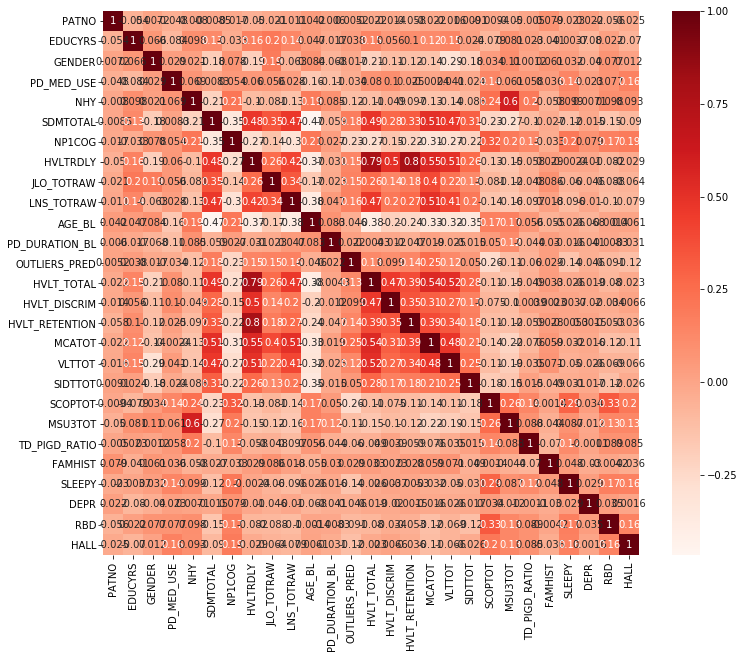

In [41]:
preprocess(data)

#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### In this cell we seperate out data set into training and test sets and apply standardization to numeric columns

In [42]:
#We have to ensure that all longitudinal observations from one patient ends up in the same sample
tempdata = pd.DataFrame(data.PATNO.unique(), columns = ["PATNO"])

HALL_EVER = []
for id in data.PATNO.unique():

    if data.loc[(data.PATNO == id) & (data.HALL == 1), "HALL"].empty:
        HALL_EVER.append(0)
    else:
        HALL_EVER.append(1)

print("Number of patients which hallucinates eventually: ",  sum(HALL_EVER), " which is ", sum(HALL_EVER)/ len(HALL_EVER), " percent of patients" )
    
Y = HALL_EVER
X = tempdata


train, test, _, _ = train_test_split( X, Y, test_size= TEST_PORTION, random_state= 1, stratify= Y)

train = data.merge(train, how = "inner", on = "PATNO")
test = data.merge(test, how = "inner", on = "PATNO")

Number of patients which hallucinates eventually:  101  which is  0.24162679425837322  percent of patients


#### In this cell we apply standardization to numeric columns and output train and test to disk

In [43]:
def standardize_df (df, standardization):
    
    pd.set_option('mode.chained_assignment', None)
    columns = standardization.loc[:, "COLUMN_NAME"].values
    for i,c in enumerate(columns):
        df.loc[:,c] -= standardization.at[i,"MEAN"]
        df.loc[:,c] /= standardization.at[i,"STD"]
        
    pd.set_option('mode.chained_assignment', "warn")


column_types = pd.read_csv("Column_Data_Types_Final.csv")

numeric_columns = column_types.loc[column_types.DATA_TYPE == "Numeric", "COLUMN_NAME"].values
numeric_columns = np.intersect1d(numeric_columns, data.columns.values)

mean = np.mean(train.loc[:, numeric_columns])
std = np.std(train.loc[:, numeric_columns])

standardization = pd.DataFrame(numeric_columns, columns = ["COLUMN_NAME"])
standardization["MEAN"] = mean.values
standardization["STD"] = std.values

#Saving the standardization so we can later apply to test data
standardization.to_csv(output_filepath + '/standardization.csv', index = False)

standardize_df(train, standardization)

#Output train and test to disk

train.to_csv(output_filepath + '/train.csv', index = False)
test.to_csv(output_filepath + '/test.csv', index = False)




#### In this cell we explore the distribution of our response HALL over time

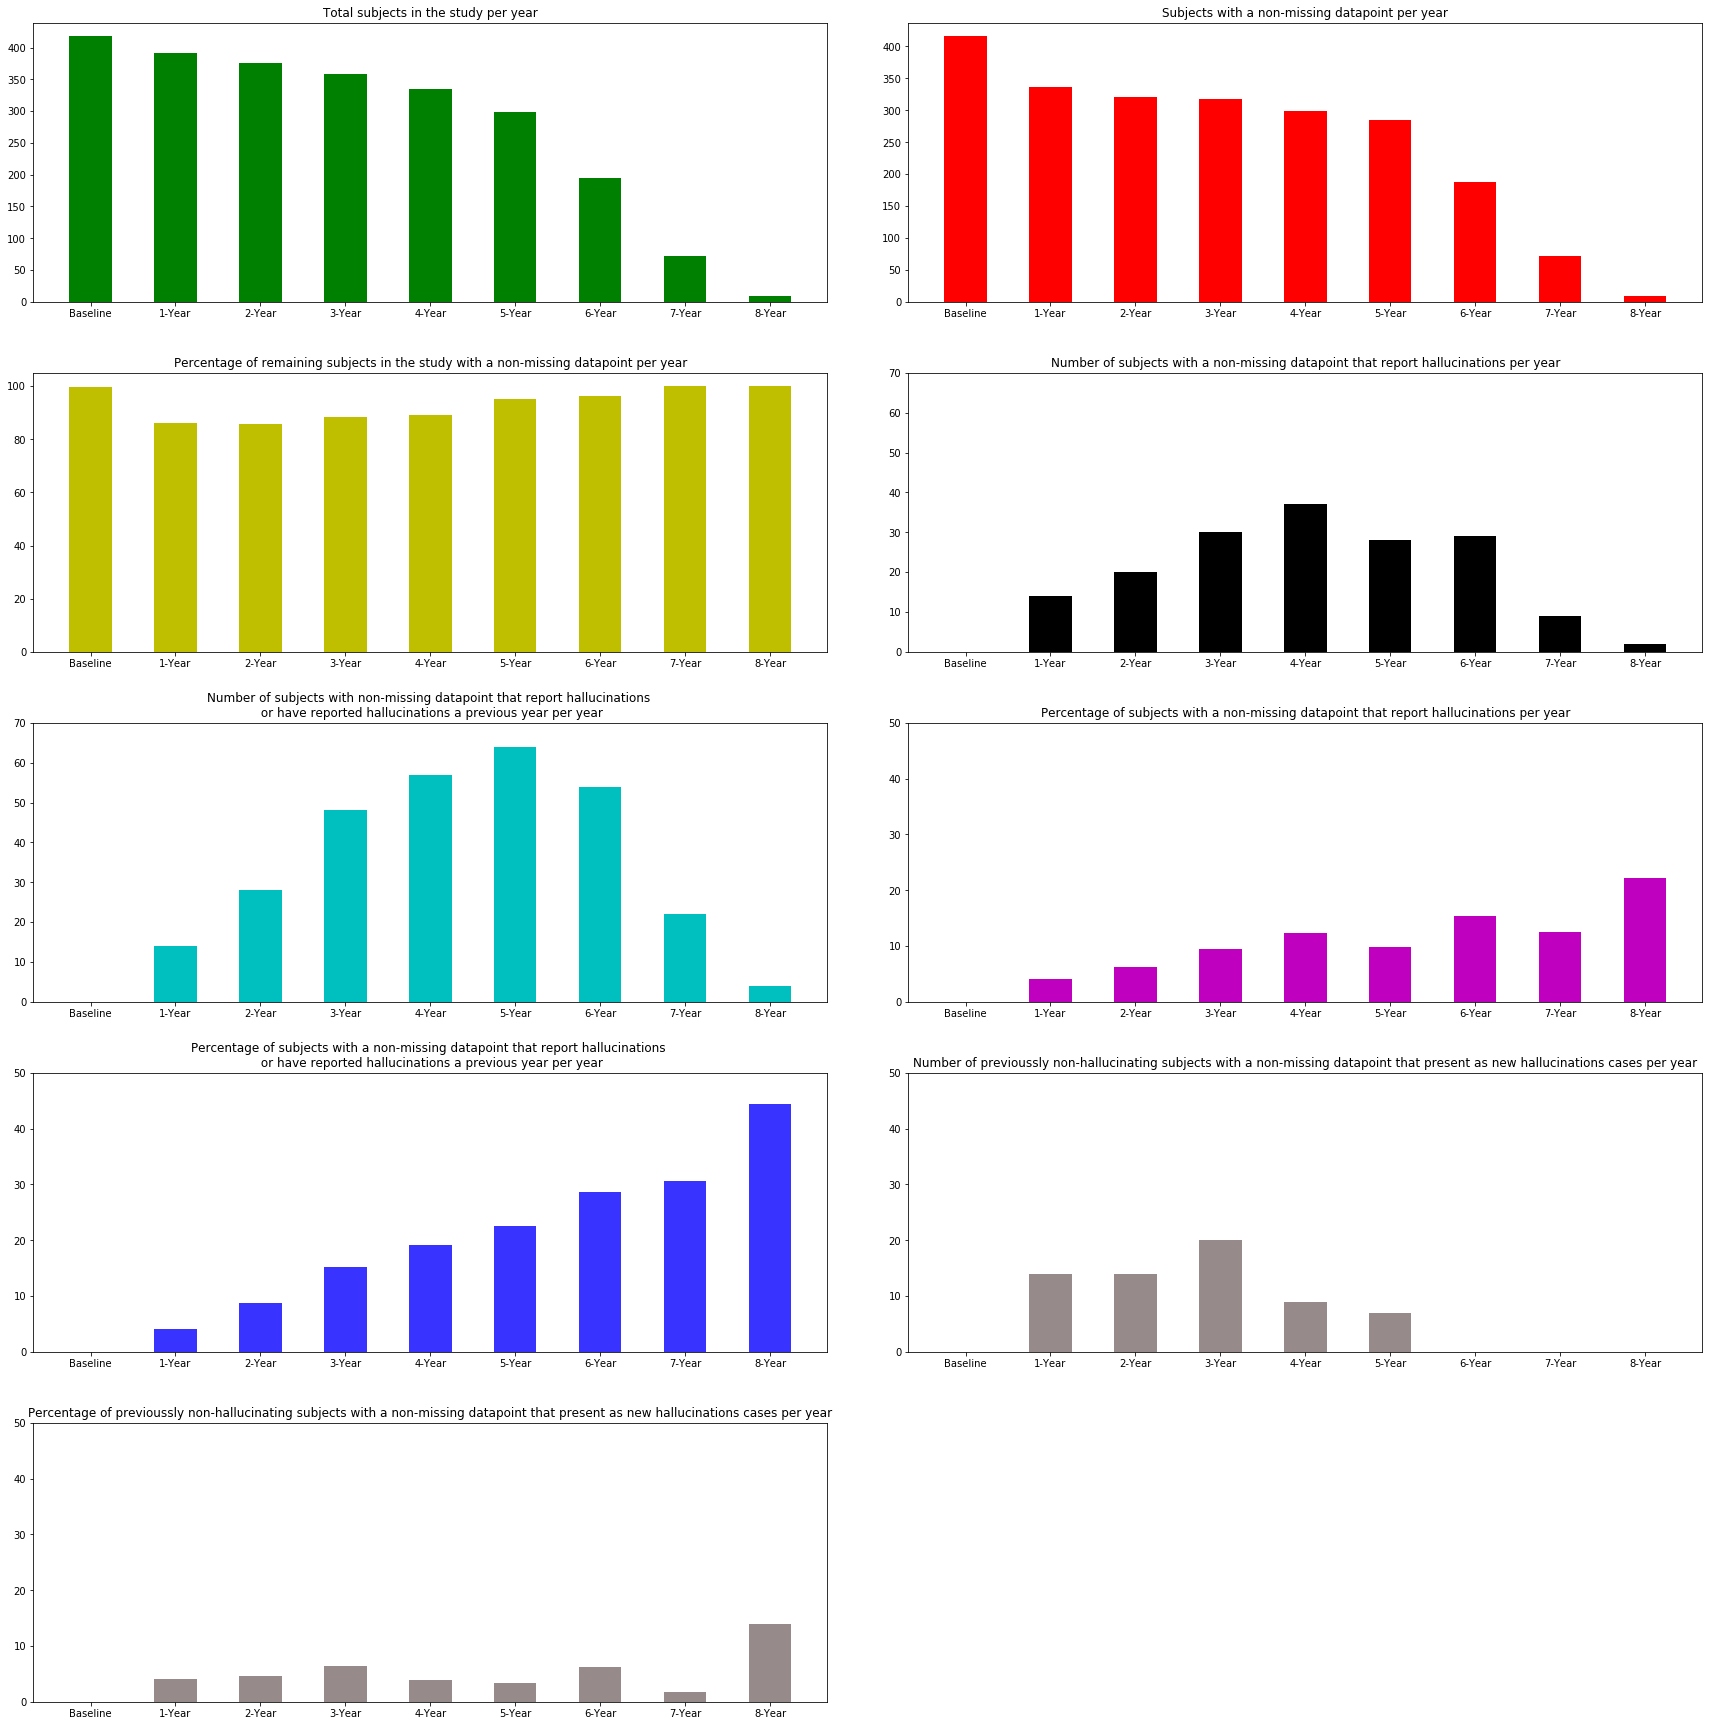

In [45]:
tempdata = data.copy(deep = True)
unique_patno = data.PATNO.unique()
event_ids = np.sort(data.EVENT_ID.unique())
for x in unique_patno:
    subject_data = tempdata.loc[tempdata.PATNO == x, ["EVENT_ID", "HALL"]]
    subject_event_ids = np.sort(subject_data.EVENT_ID.unique())
    first_hall = 0
    for i in subject_event_ids:
        if first_hall != 1 and subject_data.loc[subject_data.EVENT_ID == i, ["HALL"]].values[0] == 1:
                first_hall = 1
        elif first_hall == 1:
                tempdata.loc[(tempdata.PATNO == x) & (tempdata.EVENT_ID == i), ["HALL"]] = 1

event_id_to_years = {
    "BL" : "Baseline",
    "V04": "1-Year",
    "V06": "2-Year",
    "V08": "3-Year",
    "V10": "4-Year",
    "V12": "5-Year",
    "V13": "6-Year",
    "V14": "7-Year",
    "V15": "8-Year"   
}

'''
distribution1 = Total subjects in the study per year
distribution2 = Subjects with a non-missing datapoint per year
distribution3 = Percentage of remaining subjects in the study with a non-missing datapoint per year
distribution4 = Number of subjects with a non-missing datapoint that report hallucinations per year
distribution5 = Number of subjects with a non-missing datapoint that report hallucinations or have reported hallucinations a previous years per year
distribution6 = Percentage of subjects with a non-missing datapoint that report hallucinations per year
distribution7 = Percentage of subjects with a non-missing datapoint that report hallucinations or have reported hallucinations previous years per year
distribution8 = Number of previoussly non-hallucinating subjects with a non-missing datapoint that present as new hallucinations cases per year
distribution9 = Percentage of previously non-hallucinating subjects with a non-missing datapoint that present as new hallucinations cases per year
'''

#Total subjects in the study per year
distribution1 = {}

subjects = data.PATNO.unique().size
for x in event_ids:
    distribution1 [event_id_to_years[x]] = subjects
    subjects -= data.loc[data.LAST_EVENT_ID == x, "PATNO"].unique().size
        

#Subjects with a datapoint per year
distribution2 = {}

for x in event_ids:
    distribution2 [event_id_to_years[x]] = data.loc[data.EVENT_ID == x, "PATNO"].unique().size

    

#Percentage of remaining subjects with a datapoint per year       
distribution3 = {}
subjects = data.PATNO.unique().size
for x in event_ids:
    distribution3 [event_id_to_years[x]] = (data.loc[data.EVENT_ID == x, "PATNO"].unique().size / subjects) * 100
    subjects -= data.loc[data.LAST_EVENT_ID == x, "PATNO"].unique().size
    

# Number of subjects with a datapoint that report hallucinations per year
distribution4 = {}
for x in event_ids:
    subjects_hall = data.loc[(data.EVENT_ID == x) & (data.HALL == 1), "PATNO"].values
    distribution4[event_id_to_years[x]] = subjects_hall.size 
    

#Number of subjects with a datapoint that report hallucinations or have reported hallucinations priorly per year
distribution5 = {}

for x in event_ids:
    subjects_hall = tempdata.loc[(tempdata.EVENT_ID == x) & (tempdata.HALL == 1), "PATNO"].values
    distribution5[event_id_to_years[x]] = subjects_hall.size 
        

#Percentage of subjects with a non-missing datapoint that report hallucinations per year
distribution6 = {}

for x in event_ids:
    subjects_hall = data.loc[(data.EVENT_ID == x) & (data.HALL == 1), "PATNO"].values
    distribution6[event_id_to_years[x]] = (subjects_hall.size / data.loc[data.EVENT_ID == x, "PATNO"].unique().size) * 100
    
#Percentage of subjects with a non-missing datapoint that report hallucinations or have reported hallucinations previous years per year
distribution7 = {}

for x in event_ids:
    subjects_hall = tempdata.loc[(tempdata.EVENT_ID == x) & (tempdata.HALL == 1), "PATNO"].values
    distribution7[event_id_to_years[x]] = (subjects_hall.size / data.loc[data.EVENT_ID == x, "PATNO"].unique().size) * 100
        
#Number of previoussly non-hallucinating subjects with a non-missing datapoint that present as new hallucinations cases per year
distribution8 = {}

previous_key = "Baseline"

for k,v in distribution5.items():
    
    distribution8[k] = v - distribution5[previous_key]
    previous_key = k

#Percentage of previoussly non-hallucinating subjects with a non-missing datapoint that present as new hallucinations cases per year
distribution9 = {}

previous_key = "Baseline"

for k,v in distribution7.items():
    
    distribution9[k] = v - distribution7[previous_key]
    previous_key = k

fig, axs = plt.subplots(5, 2)
fig.set_size_inches(25, 25)
fig.tight_layout(pad=5.0)
fig.delaxes(axs[4,1])


# distribution1 = Total subjects in the study per year
axs[0,0].bar(distribution1.keys(), distribution1.values(), width=.5, color='g')
axs[0,0].title.set_text("Total subjects in the study per year")

#distribution2 = Subjects with a non-missing datapoint per year
axs[0,1].bar(distribution2.keys(), distribution2.values(), width=.5, color='r')
axs[0,1].title.set_text("Subjects with a non-missing datapoint per year")

#distribution3 = Percentage of remaining subjects in the study with a non-missing datapoint per year
axs[1,0].bar(distribution3.keys(), distribution3.values(), width=.5, color='y')
axs[1,0].title.set_text("Percentage of remaining subjects in the study with a non-missing datapoint per year")

#distribution4 = Number of subjects with a non-missing datapoint that report hallucinations per year
axs[1,1].set_ylim(0,70)
axs[1,1].bar(distribution4.keys(), distribution4.values(), width=.5, color='k')
axs[1,1].title.set_text("Number of subjects with a non-missing datapoint that report hallucinations per year")

#distribution5 = Number of subjects with non-missing datapoint that report hallucinations \n or have reported hallucinations a previous year per year
axs[2,0].set_ylim(0,70)
axs[2,0].bar(distribution5.keys(), distribution5.values(), width=.5, color='c')
axs[2,0].title.set_text("Number of subjects with non-missing datapoint that report hallucinations \n or have reported hallucinations a previous year per year")

#distribution6 = Percentage of subjects with a non-missing datapoint that report hallucinations per year
axs[2,1].set_ylim(0,50)
axs[2,1].bar(distribution6.keys(), distribution6.values(), width=.5, color='m')
axs[2,1].title.set_text("Percentage of subjects with a non-missing datapoint that report hallucinations per year")

#distribution7 = Percentage of subjects with a non-missing datapoint that report hallucinations or have reported hallucinations a previous year per year
axs[3,0].set_ylim(0,50)
axs[3,0].bar(distribution7.keys(), distribution7.values(), width=.5, color= '#3933FF')
axs[3,0].title.set_text("Percentage of subjects with a non-missing datapoint that report hallucinations \n or have reported hallucinations a previous year per year")

#Number of previoussly non-hallucinating subjects with a non-missing datapoint that present as new hallucinations cases per year
axs[3,1].set_ylim(0,50)
axs[3,1].bar(distribution8.keys(), distribution8.values(), width=.5, color= '#978A8A')
axs[3,1].title.set_text("Number of previoussly non-hallucinating subjects with a non-missing datapoint that present as new hallucinations cases per year")

#Percentage of previoussly non-hallucinating subjects with a non-missing datapoint that present as new hallucinations cases per year
axs[4,0].set_ylim(0,50)
axs[4,0].bar(distribution9.keys(), distribution9.values(), width=.5, color= '#978A8A')
axs[4,0].title.set_text("Percentage of previoussly non-hallucinating subjects with a non-missing datapoint that present as new hallucinations cases per year")
